## Using Machine Learning to Classify Pitch Type

This notebook is a Python implementation of a DecisionTree model to train MLB pitching data to predict pitches.

The data is from BaseballSavant and contains every pitch from the MLB 2021 regular season. You can download the dataset from [BaseballSavant] (https://baseballsavant.mlb.com/statcast_search). The dates for this data are 4/1/21 - 10/3/21

Note: Since the data was originally for a different project, it has already been cleaned. 

### Importing Packages and Data

In [1]:
# General Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [11]:
data_raw = pd.read_csv('savant_2021_regular.csv').drop(['Unnamed: 0'], axis=1)
#data_raw.dropna(inplace = True)

### Basic EDA
Let's look at all the different pitches in the data:

In [12]:
data_raw.groupby(['pitch_name']).size().reset_index().rename(columns={0:'count'})

,pitch_name,count
0,4-Seam Fastball,250512
1,Changeup,80637
2,Curveball,59251
3,Cutter,47628
4,Eephus,76
5,Fastball,725
6,Knuckle Curve,13732
7,Knuckleball,81
8,Screwball,1
9,Sinker,109613


There is a pitch named 'Fastball'. I'm going to combine that with '4-Seam Fastball' so that the model doesn't think they are two different pitches.

In [13]:
# Changing Fastball to 4-Seam Fastball
data_raw['pitch_name'].mask(data_raw['pitch_name'] == 'Fastball', data_raw['pitch_name'].str.lower(), inplace=True)
data_raw['pitch_name'].mask(data_raw['pitch_name'] == 'fastball', '4-Seam Fastball', inplace=True)
data_raw.groupby(['pitch_name']).size().reset_index().rename(columns={0:'count'})

,pitch_name,count
0,4-Seam Fastball,251237
1,Changeup,80637
2,Curveball,59251
3,Cutter,47628
4,Eephus,76
5,Knuckle Curve,13732
6,Knuckleball,81
7,Screwball,1
8,Sinker,109613
9,Slider,136047


Eephus, Knuckleball, Screwball all occur less than 100 times. Since they rarely are thrown, let's drop them.

In [19]:
# Dropping pitches with a count less than 100 
x = data_raw.groupby(['pitch_name']).size().reset_index().rename(columns={0:'count'})
rare = x.loc[x['count'] < 100]
rare = rare['pitch_name'].to_list()

rare

['Eephus', 'Knuckleball', 'Screwball']

In [25]:
df = data_raw.loc[~data_raw['pitch_name'].isin(rare)]

In [28]:
df['pitch_name'].dropna(inplace=True)

As a baseball fan, I know that release speed and spin rate are important in determining pitch classification. But let's visualize those two factors to see:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


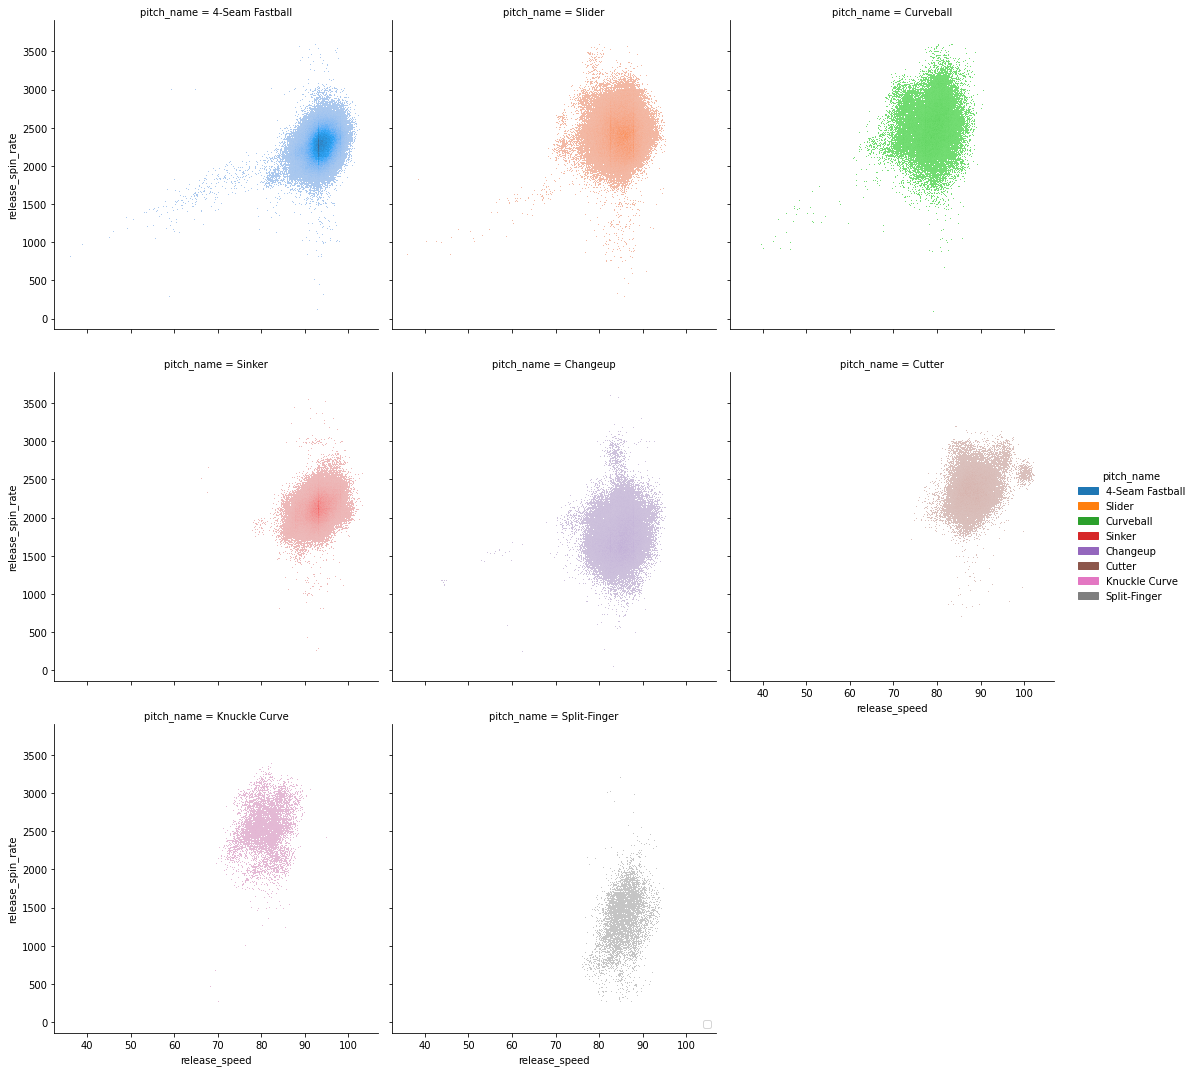

In [33]:
sns.displot(x='release_speed', y='release_spin_rate', 
                hue='pitch_name', col='pitch_name',
                data=df,  col_wrap=3)
plt.legend(loc='lower right', markerscale=2)

#s = 25,
#alpha = 0.5
#plot_ = sns.scatterplot(x='release_speed', y='release_spin_rate', hue='pitch_name', data= plot_data)

In general, it appears that release speed and spin rate do have a correlation with pitch name classifcation.

## Machine Learning

The features, or varibles, used to model pitch name will be: 
-release_speed
-release_spin_rate
-vx0, vy0, vz0
-ax, ay, az

All of the features have something to do with pitch speed or spin.

In [34]:
data = df.loc[:,['pitch_name',
                       'release_speed',
                       'release_spin_rate',
                       'vx0','vy0','vz0',
                       'ax','ay','az']]

data = data.dropna()

### Splitting Data 
Below I split the dataset into two sets:
1. **x** contains all of the features (variables) that will be used to predict the outcome(pitch_type). 
2. **y** contains only pith_type (the target outcome)

Using the train_test_split function, the original data is split into: 
1. **training** set - the dataframe that will be passed through the model and used to train it
2. **testing** set - the dataframe that will be used to once the model has been trained to see how well it did

In [35]:
x = ['release_speed','vx0','vy0','vz0','ax','ay','az','release_spin_rate']
y = 'pitch_name'

#Splitting data 80% train, 20% test
train, test = train_test_split(data, test_size=0.2)

In [36]:
#Defining the DecisionTreeClassifier model
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=50)
#Training the model
dt.fit(train[x], train[y])

DecisionTreeClassifier(max_depth=10, min_samples_split=50)

Now that the model has been trained using the trained, we can run it on the testing dataset. We will use test[x] which contains all the feature varibles. The model will predict what it thinks test[y] will be. We can then use the actual test[y] dataset to see how well the model did. 

In [37]:
# Now the trained model will use test[x] to predict test[y]
y_pred = dt.predict(test[x])
acc_dt = (accuracy_score(y_pred, test[y])*100).round(2)
print('Test Set Accuracy Score: {0} %'.format(acc_dt.round(2)))

Test Set Accuracy Score: 82.25 %


82.25 % is not too shabby! Next, I'm going to add the model predictions to the test dataframe so we can see what may have tricked model. This new column will be called 'pitch_hat' (hat comes from statistics). We'll also add a 'correct' column so we can easily see if the model got that specifc instance correct.

In [38]:
test['pitch_hat'] = y_pred
test['correct'] = (test['pitch_hat'] == test['pitch_name'])
test.head()

,pitch_name,release_speed,release_spin_rate,vx0,vy0,vz0,ax,ay,az,pitch_hat,correct
668593,4-Seam Fastball,97.4,2427.0,8.247172,-141.626612,-3.148607,-20.180391,34.354239,-16.205179,4-Seam Fastball,True
660147,Curveball,81.8,2675.0,-0.564882,-119.161761,-0.735895,9.842413,21.429881,-39.754273,Curveball,True
218480,4-Seam Fastball,97.1,2305.0,4.350883,-141.476001,-3.810690,-8.101331,29.346676,-13.947762,4-Seam Fastball,True
267239,Knuckle Curve,85.7,2056.0,3.102474,-124.823963,-2.343283,5.931482,25.808440,-41.764859,Curveball,False
597491,Curveball,75.9,2454.0,-2.206612,-110.574623,-1.839947,-5.583939,19.285389,-30.626409,Slider,False


Using classification_report, we can see how precise the model was with each pitch_name

In [39]:
print(classification_report(y_pred, test[y]))

                 precision    recall  f1-score   support

4-Seam Fastball       0.93      0.91      0.92     51194
       Changeup       0.87      0.84      0.85     16602
      Curveball       0.75      0.75      0.75     11880
         Cutter       0.43      0.61      0.50      6624
  Knuckle Curve       0.21      0.65      0.32       866
         Sinker       0.80      0.83      0.81     20946
         Slider       0.89      0.75      0.81     32228
   Split-Finger       0.33      0.75      0.46       937

       accuracy                           0.82    141277
      macro avg       0.65      0.76      0.68    141277
   weighted avg       0.85      0.82      0.83    141277



The model did very well with 4-Seam Fastballs, but had a problem with Split-Fingers. Next, I'm going to add the prediction probabilities to see what pitch types the model had the most trouble with, and what the model thought it was.

In [40]:
probs = pd.DataFrame(dt.predict_proba(test[x]), index=test.index, columns=dt.classes_)

In [42]:
results = pd.concat([test[['pitch_name', 'pitch_hat', 'correct']], probs], axis=1)
results = results.round(2)

results.groupby('pitch_name')[['correct'] + list(probs.columns)].mean().round(2)

,correct,4-Seam Fastball,Changeup,Curveball,Cutter,Knuckle Curve,Sinker,Slider,Split-Finger
pitch_name,,,,,,,,,
4-Seam Fastball,0.93,0.88,0.01,0.00,0.03,0.00,0.08,0.01,0.00
Changeup,0.87,0.02,0.78,0.01,0.01,0.00,0.10,0.02,0.07
Curveball,0.75,0.00,0.01,0.63,0.01,0.12,0.00,0.22,0.00
Cutter,0.43,0.16,0.01,0.01,0.40,0.00,0.01,0.40,0.00
Knuckle Curve,0.21,0.00,0.00,0.53,0.01,0.32,0.00,0.13,0.00
Sinker,0.80,0.18,0.07,0.00,0.00,0.00,0.73,0.00,0.00
Slider,0.89,0.01,0.01,0.10,0.14,0.01,0.00,0.71,0.00
Split-Finger,0.33,0.01,0.53,0.00,0.01,0.00,0.03,0.02,0.40


The seems to have trouble distinguishing between the different pitch groups: fastballs and off-speed pitches. 

Fastballs | Off Speed 
--- | --- 
4-Seam| Curveball 
Sinker| Knuckle Curve
Cutter | Slider
Split | Changeup

### Pitch Grouping Model

Since the model had issues with the different types of fastballs and the different types of off-speed pitches, I'm going to create a pitch group column with the values classifying each as a fastball or an off-speed pitch.

In [44]:
#Creating pitch groupings
conditions = [(
    (df['pitch_name'] == '4-Seam Fastball') | 
    (df['pitch_name'] == 'Sinker') |
    (df['pitch_name'] == 'Cutter') |
    (df['pitch_name'] == 'Split-Finger'))]
values = [1]

df['pitch_group'] = np.select(conditions, values)

In [45]:
replacement_mapping_dict = {0: 'off-speed', 1: "fastball"}
df['pitch_group'] = df['pitch_group'].replace(replacement_mapping_dict)

Let's run the model again to see if it's any more accurate than the first one.

In [46]:
data = df.loc[:,['pitch_group',
                       'release_speed',
                       'release_spin_rate',
                       'vx0','vy0','vz0',
                       'ax','ay','az']]

data = data.dropna()

In [47]:
x = ['release_speed','vx0','vy0','vz0','ax','ay','az','release_spin_rate']
y = 'pitch_group'

#Splitting data 80% train, 20% test
train, test = train_test_split(data, test_size=0.2)

In [49]:
#Defining the DecisionTreeClassifier model
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=50)
#Training the model
dt.fit(train[x], train[y])

DecisionTreeClassifier(max_depth=10, min_samples_split=50)

In [50]:
# Now the trained model will use test[x] to predict test[y]
y_pred = dt.predict(test[x])
acc_dt = (accuracy_score(y_pred, test[y])*100).round(2)
print('Test Set Accuracy Score: {0} %'.format(acc_dt.round(2)))

Test Set Accuracy Score: 92.9 %


Wow! Almost 93% a great! Remember the original testing set was around 82%.

In [51]:
test['pitch_hat'] = y_pred
test['correct'] = (test['pitch_hat'] == test['pitch_group'])

In [52]:
print(classification_report(y_pred, test[y]))

              precision    recall  f1-score   support

    fastball       0.93      0.95      0.94     81561
   off-speed       0.93      0.90      0.91     59716

    accuracy                           0.93    141277
   macro avg       0.93      0.92      0.93    141277
weighted avg       0.93      0.93      0.93    141277



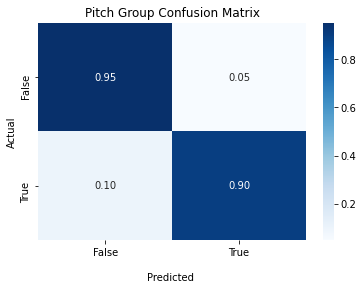

In [53]:
cm = confusion_matrix(y_pred, test[y])
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cmnorm, annot=True, fmt='.2f', cmap='Blues')

ax.set_title('Pitch Group Confusion Matrix');
ax.set_xlabel('\nPredicted ')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

The top row of the confusion matrix shows the model correctly predicited 90% of the pitches were off-speed. The model incorrectly predicted 10% of pitches were not off-speed, even though they were.

The bottom row shows the model incorrectly predicted 5% of the pitches were fastballs and
correctly predicited 95% of fastballs.

### Visualizations

In [54]:
os = test[test['pitch_group']== 'off-speed']
fb = test[test['pitch_group']== 'fastball']

fb_sample = fb.sample(5000)
os_sample = os.sample(5000)
test_sample = test.sample(5000)

In [55]:
os_wrong= os_sample[os_sample['correct'] == 0]
fb_wrong= fb_sample[fb_sample['correct'] == 0]
test_wrong = test_sample[test_sample['correct'] == 0]

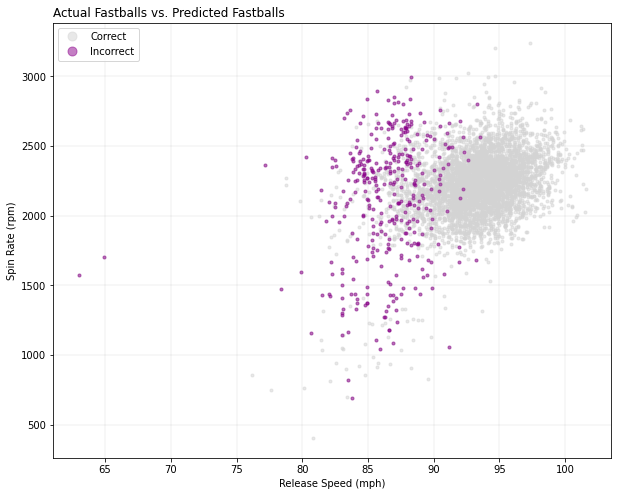

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
# Plot the whole dataset
plt.plot('release_speed', 'release_spin_rate', "", data= fb_sample, 
            linestyle='', marker='o', markersize=3, color="lightgrey", 
            alpha=0.5, label='Correct')

# Add the group to study
plt.plot('release_speed', 'release_spin_rate', "", data= fb_wrong, 
            linestyle='', marker='o', markersize=3,  color = 'darkmagenta',
            alpha=0.5, label='Incorrect')
# Add major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
 
# Add titles and legend
plt.xlabel('Release Speed (mph)', horizontalalignment='center')
plt.ylabel('Spin Rate (rpm)', horizontalalignment='center')
plt.title('Actual Fastballs vs. Predicted Fastballs', loc = 'left')
plt.legend(markerscale=3)

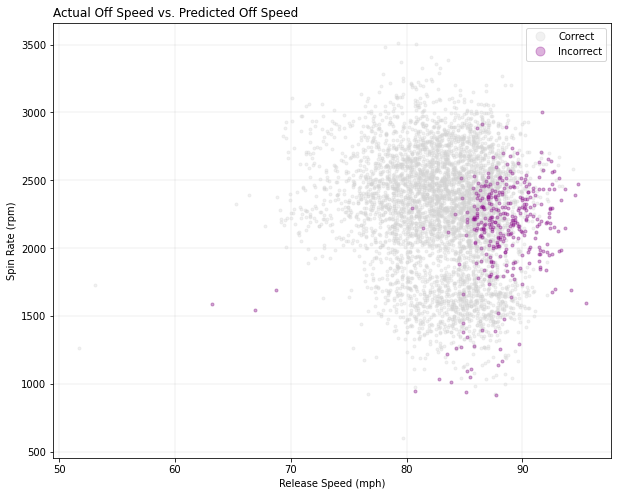

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))
# Plot the whole dataset
plt.plot('release_speed', 'release_spin_rate', "", data= os_sample, 
            linestyle='', marker='o', markersize=3, color="lightgrey", 
            alpha=0.3, label='Correct')

# Add the group to study
plt.plot('release_speed', 'release_spin_rate', "", data= os_wrong, 
            linestyle='', marker='o', markersize=3,  color = 'darkmagenta',
            alpha=0.3, label='Incorrect')
# Add major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
 
# Add titles and legend
plt.xlabel('Release Speed (mph)', horizontalalignment='center')
plt.ylabel('Spin Rate (rpm)', horizontalalignment='center')
plt.title('Actual Off Speed vs. Predicted Off Speed', loc = 'left')
plt.legend(markerscale=3)

## Final Thoughts

The second model with just the two pitch group classifcations saw a 10% increase in accuracy scoring. On the graphs where the incorrect pitches are highlighted, it's clear the model had a difficult time with pitches between 85-90 mph. This is likely due to different pitchers being able to throw different speeds- a pitcher who can throw a 100 mph fastball may have an off speed pitch in the low 90s. Similarily, a pitcher that is more known for pitch movement may top out at 88-90 mph. 

In the future, I'd like to try the model on all of the pitches for a single pitcher. The model *should* be more accurate for those pitchers with distinct pitching characteristics. 